In [1]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

import numpy as np
from time import time

import psutil
from sklearn.neighbors import NearestNeighbors

from matplotlib.patches import Rectangle

from sklearn.preprocessing import StandardScaler
from pyspark.ml.feature import VectorAssembler

import geopandas as gpd
import folium
import matplotlib.colors as mcolors

from sklearn.metrics import silhouette_score

from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType, FloatType
from pyspark.sql.functions import floor, col,when, lit, expr, monotonically_increasing_id, expr, max, min, col, pandas_udf, PandasUDFType

from scipy.spatial import KDTree

from pyspark.sql.window import Window

from matplotlib.patches import Rectangle
import numpy as np

from pyspark.sql.functions import udf

import networkx as nx

In [3]:
from pyspark.sql import SparkSession
# Initialize a Spark session
spark = SparkSession.builder.appName("GeoLifeData").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/13 12:39:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:

def read_plt_files_spark(directory, sample_fraction=1.0):
    plt_data = []
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename.endswith('.plt'):
                filepath = os.path.join(root, filename)
                try:
                    with open(filepath, 'r') as file:
                        lines = file.readlines()[6:]  # Skip header
                        sample_size = int(len(lines) * sample_fraction)
                        lines = np.random.choice(lines, sample_size, replace=False)
                        for line in lines:
                            parts = line.strip().split(',')
                            if len(parts) >= 7:
                                plt_data.append((float(parts[0]), float(parts[1])))
                except Exception as e:
                    print(f"Failed to process {filename}: {e}")

    # Create an RDD
    rdd = spark.sparkContext.parallelize(plt_data)
    
    # Convert RDD to DataFrame
    df = spark.createDataFrame(rdd, ["Latitude", "Longitude"])
    return df

# Set the path to the directory containing the data
root_directory = '/kaggle/input/geodata/Geolife Trajectories 1.3/Data'

# Load and sample the data
spark_df = read_plt_files_spark(root_directory, sample_fraction=0.001)

# Show the data
spark_df.show()

+---------+----------+
| Latitude| Longitude|
+---------+----------+
|26.711523|111.821227|
| 32.08498|114.111732|
|26.436406|111.597074|
|39.335023| 115.85899|
| 35.99075|114.345399|
|29.774346|114.048147|
|31.030467|113.920045|
|38.425628|114.827118|
|39.407743|115.919343|
|26.633923|111.695399|
|26.439671|111.566211|
|32.128144|114.080619|
| 38.07351|114.492652|
|26.430739|111.601406|
|37.037063|114.483895|
|34.565022|113.809346|
|29.724563|113.928372|
|26.863655|112.473307|
|27.301462|112.957277|
|32.969974|114.037359|
+---------+----------+
only showing top 20 rows



In [5]:
# Number of rows
num_rows = spark_df.count()
print("Number of rows:", num_rows)

Number of rows: 17823


+---------+----------+------------+
| Latitude| Longitude|Partition_ID|
+---------+----------+------------+
|26.711523|111.821227|           7|
| 32.08498|114.111732|           7|
|26.436406|111.597074|           7|
|39.335023| 115.85899|           7|
| 35.99075|114.345399|           7|
|29.774346|114.048147|           7|
|31.030467|113.920045|           7|
|38.425628|114.827118|           7|
|26.633923|111.695399|           7|
|26.439671|111.566211|           7|
|32.128144|114.080619|           7|
| 38.07351|114.492652|           7|
|26.430739|111.601406|           7|
|37.037063|114.483895|           7|
|34.565022|113.809346|           7|
|29.724563|113.928372|           7|
|26.863655|112.473307|           7|
|27.301462|112.957277|           7|
|32.969974|114.037359|           7|
|39.250723|115.779148|           7|
+---------+----------+------------+
only showing top 20 rows



+------------+-----+
|Partition_ID|count|
+------------+-----+
|           7| 1958|
|           8| 2120|
|           9| 2107|
|          10| 2353|
|          11| 2081|
|          12| 2287|
|          13| 2331|
|          14| 2586|
+------------+-----+



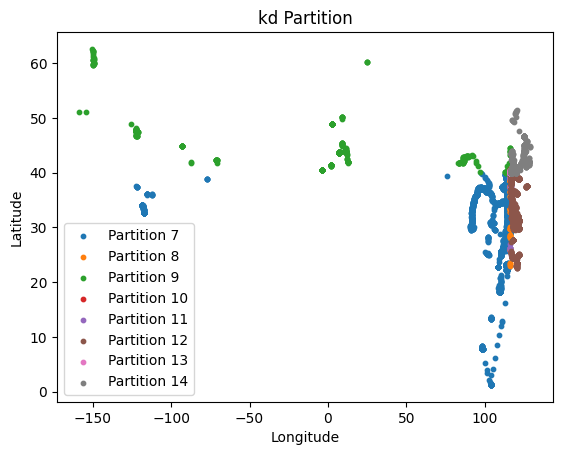

In [6]:


#tested quadtree partitioning and adaptive grid partitioning

def kdtree_partitioning(df, depth=0, max_depth=3, partition_id=0):
    # Base case: if maximum depth is reached, return the dataframe with a final partition ID
    if depth >= max_depth:
        return df.withColumn("Partition_ID", lit(partition_id))
    
    # Decide which dimension to split on: 0 for longitude, 1 for latitude
    split_dimension = 'Longitude' if depth % 2 == 0 else 'Latitude'
    
    # Calculate the median of the current dimension
    median_value = df.stat.approxQuantile(split_dimension, [0.5], 0.05)[0]
    
    # Split the dataframe into two parts based on the median
    left_df = df.filter(col(split_dimension) < median_value)
    right_df = df.filter(col(split_dimension) >= median_value)
    
    # Recursively partition each subset, increasing the partition ID based on depth
    left_id = partition_id * 2 + 1  # Create a unique partition ID for the left half
    right_id = partition_id * 2 + 2 # Create a unique partition ID for the right half
    
    left_df = kdtree_partitioning(left_df, depth + 1, max_depth, left_id)
    right_df = kdtree_partitioning(right_df, depth + 1, max_depth, right_id)
    
    # Union the dataframes from the recursive calls
    return left_df.union(right_df)

# Example usage:
# Assuming `spark_df` is already initialized and ready for partitioning
partitioned_df = kdtree_partitioning(spark_df, 0, 3)
partitioned_df.show()


partition_counts = partitioned_df.groupBy("Partition_ID").count()
partition_counts.show()

# Collect data from Spark to Pandas
pandas_df = partitioned_df.toPandas()

# Plotting
fig, ax = plt.subplots()
for partition_id, group in pandas_df.groupby("Partition_ID"):
    ax.scatter(group['Longitude'], group['Latitude'], s=10, label=f'Partition {partition_id}')

ax.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('kd Partition')
plt.show()

In [7]:
# Repartition DataFrame based on the PartitionID column
partitioned_df = partitioned_df.repartition(8 , "Partition_ID")

print(partitioned_df.rdd.getNumPartitions())
# partitioned_df.explain()

8


In [8]:
def apply_dbscan_to_partition_with_id(index, iterator):
    try : 
        data = list(iterator)
        if not data:
            return []
        # Assuming each element in data has 'Latitude' and 'Longitude' available
        data = np.array([[float(row['Latitude']), float(row['Longitude'])] for row in data])
    
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
    
        clustering = DBSCAN(eps=0.5, min_samples=20).fit(data_scaled)
        labels = clustering.labels_
    
        # Adding partition index to output
        return [Row(partition_id=index, latitude=float(row[0]), longitude=float(row[1]), cluster=int(label)) for row, label in zip(data, labels)]
    except Exception as e:
        print(f"Error in partition {index}: {str(e)}")
        raise e

# Applying the DBSCAN function to the RDD, taking into account partitioning
rdd_clustered = partitioned_df.rdd.mapPartitionsWithIndex(apply_dbscan_to_partition_with_id)

# Define a schema for the resulting DataFrame
schema_clustered = StructType([
    StructField("Partition_ID", IntegerType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Cluster", IntegerType(), True)
])

# Convert RDD back to DataFrame with the new schema
clustered_df = spark.createDataFrame(rdd_clustered, schema_clustered)
clustered_df.show()

+------------+----------+-----------+-------+
|Partition_ID|  Latitude|  Longitude|Cluster|
+------------+----------+-----------+-------+
|           0| 39.190754| 117.109159|      0|
|           0| 39.863749|  116.49358|      0|
|           0|39.9388316|116.4836483|      0|
|           0|39.9170633|116.4556566|      0|
|           0|39.9428466|116.4554483|      0|
|           0| 39.846198|  116.75585|      0|
|           0| 39.568989|  116.75799|      0|
|           0| 32.939598| 117.398659|      0|
|           0| 35.920384| 117.099025|      0|
|           0| 31.295138| 121.238012|      0|
|           0| 34.818152| 117.231268|      0|
|           0|  35.36553| 116.967488|      0|
|           0| 31.369328| 120.896957|      0|
|           0| 34.834529| 117.225957|      0|
|           0| 31.576119| 120.316681|      0|
|           0| 39.513395| 116.695954|      0|
|           0| 31.949979| 119.662277|      0|
|           0| 39.299453| 117.102262|      0|
|           0| 39.516703| 116.6902

+------------+-----+
|Partition_ID|count|
+------------+-----+
|           0| 7204|
|           1| 2107|
|           2| 2353|
|           3| 4039|
|           7| 2120|
+------------+-----+



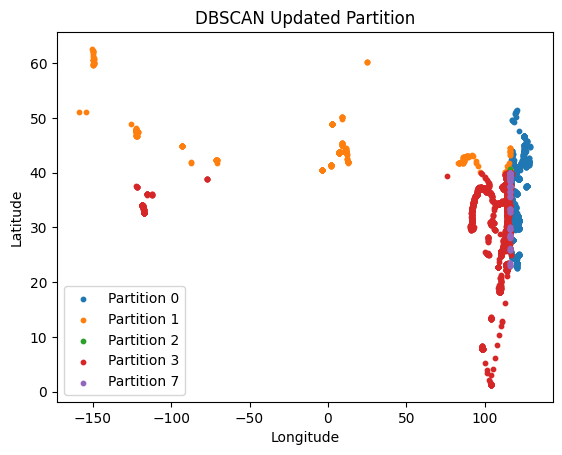

In [9]:
partition_counts = clustered_df.groupBy("Partition_ID").count()
partition_counts.show()

# Collect data from Spark to Pandas
pandas_df = clustered_df.toPandas()

# Plotting
fig, ax = plt.subplots()
for partition_id, group in pandas_df.groupby("Partition_ID"):
    ax.scatter(group['Longitude'], group['Latitude'], s=10, label=f'Partition {partition_id}')

ax.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Updated Partition')
plt.show()

/tmp/ipykernel_4337/2352414025.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('gist_rainbow')


Partition 0 has 7 clusters.
    Cluster 0 has 6741 data points.
    Cluster 1 has 54 data points.
    Cluster 2 has 69 data points.
    Cluster 3 has 20 data points.
    Cluster 4 has 64 data points.
    Cluster 5 has 20 data points.
    Cluster 6 has 189 data points.


/tmp/ipykernel_4337/2352414025.py:48: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mappable=plt.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(vmin=np.min(clusters), vmax=np.max(clusters))), label='Cluster ID')


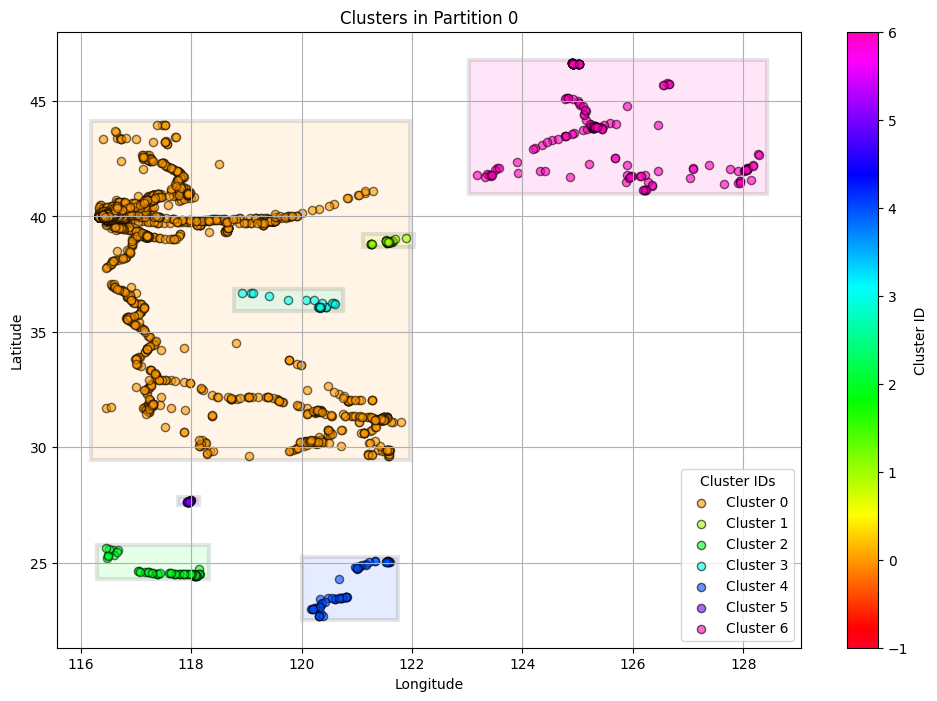

Partition 1 has 5 clusters.
    Cluster 0 has 1831 data points.
    Cluster 1 has 81 data points.
    Cluster 2 has 119 data points.
    Cluster 3 has 23 data points.
    Cluster 4 has 25 data points.


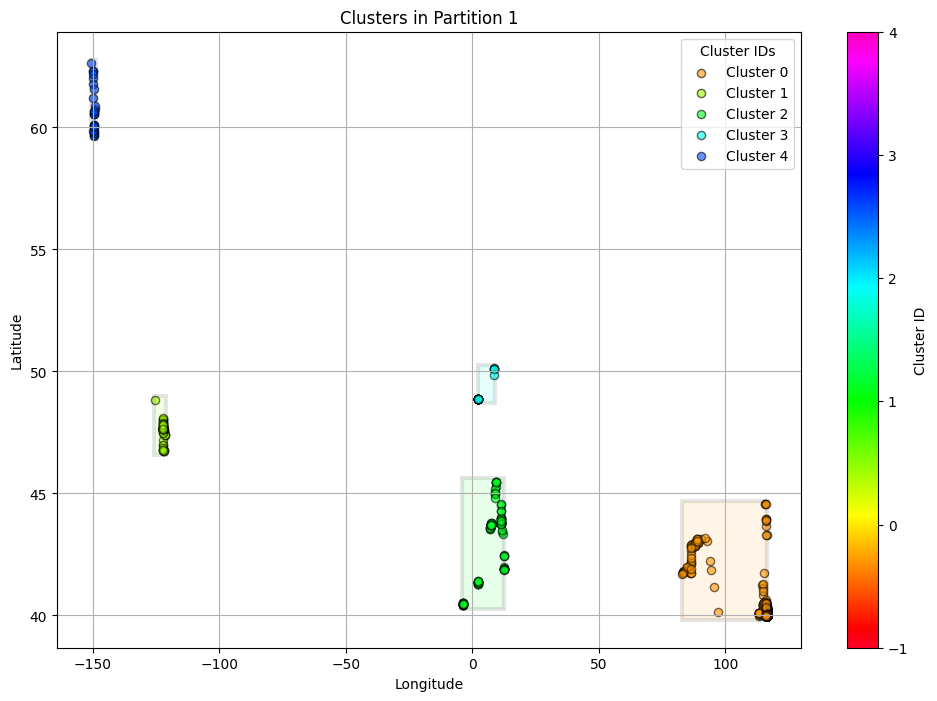

Partition 2 has 4 clusters.
    Cluster 0 has 2172 data points.
    Cluster 1 has 37 data points.
    Cluster 2 has 64 data points.
    Cluster 3 has 41 data points.


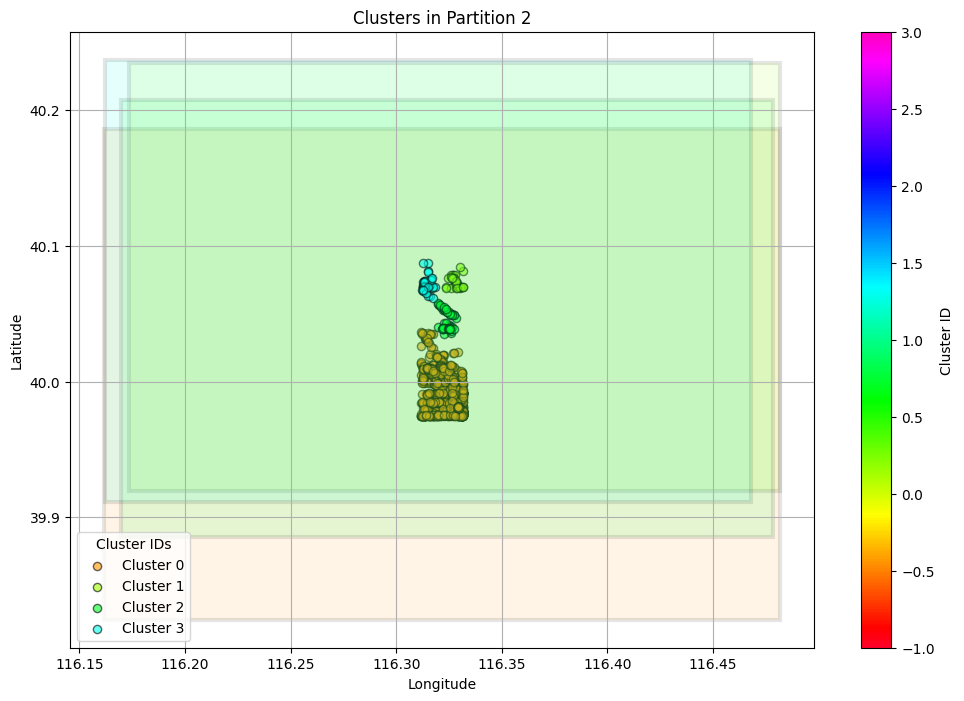

Partition 3 has 2 clusters.
    Cluster 0 has 3932 data points.
    Cluster 1 has 102 data points.


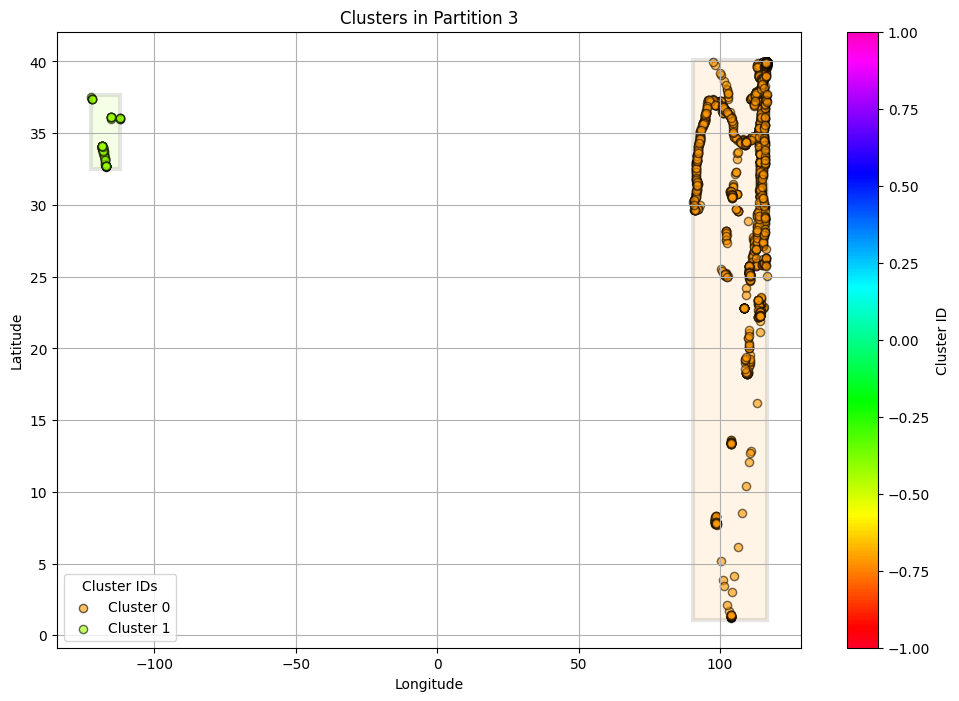

Partition 7 has 1 clusters.
    Cluster 0 has 2057 data points.


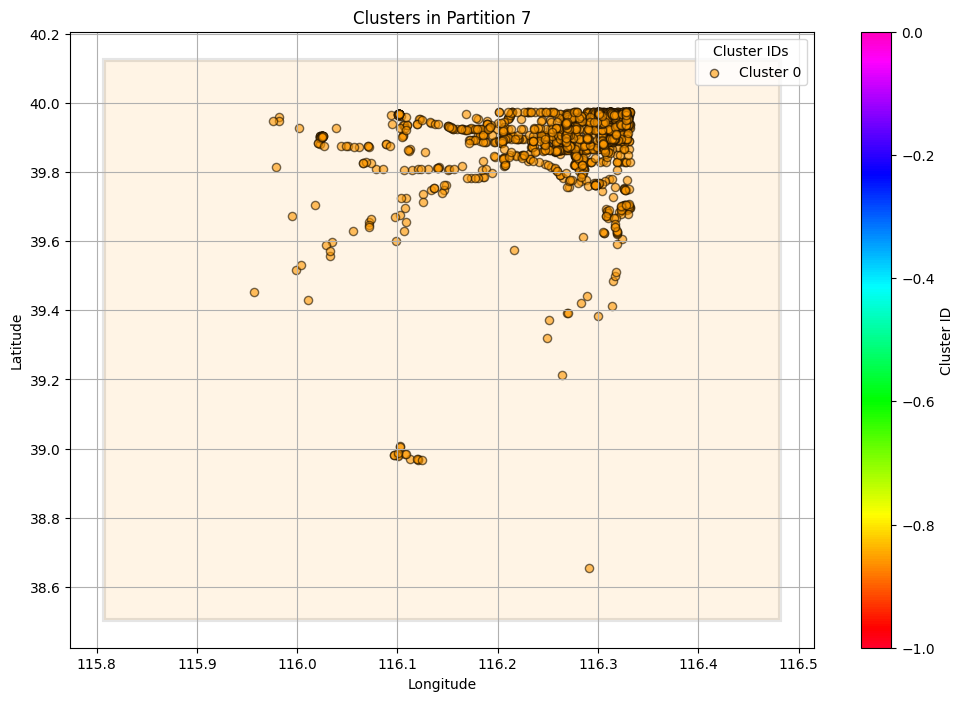

In [10]:
# Collect the data from Spark to Pandas DataFrame
pandas_df = clustered_df.toPandas()

# Determine the number of unique partitions
partitions = pandas_df['Partition_ID'].unique()

color_map = plt.cm.get_cmap('gist_rainbow')


colors = [color_map(each) for each in np.linspace(0, 1, len(np.unique(pandas_df['Cluster'])))]


# Create a separate plot for each partition
for partition_id in sorted(partitions):
    partition_data = pandas_df[pandas_df['Partition_ID'] == partition_id]
    plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
    ax = plt.gca()

    # Plot each cluster with specific color and add a rectangle
    clusters = partition_data['Cluster'].unique()
    
    cluster_count = len(clusters) - 1 if -1 in clusters else len(clusters)  # Adjust for noise label (-1)
    print(f'Partition {partition_id} has {cluster_count} clusters.')
    
    
    for i, cluster in enumerate(sorted(clusters)):
        if cluster == -1:  # -1 is typically used for noise in DBSCAN
            continue
        cluster_data = partition_data[partition_data['Cluster'] == cluster]
        color = colors[i]
        color_with_alpha = tuple(list(color[:3]) + [0.9])  # Reduce color brightness

        ax.scatter(cluster_data['Longitude'], cluster_data['Latitude'], color=color_with_alpha, edgecolor='black', s=35, alpha=0.6, label=f'Cluster {cluster}')
        
        # Calculate boundaries for the rectangle with padding
        padding = 0.15  # Increase padding to make rectangles bigger
        min_long, max_long = cluster_data['Longitude'].min() - padding, cluster_data['Longitude'].max() + padding
        min_lat, max_lat = cluster_data['Latitude'].min() - padding, cluster_data['Latitude'].max() + padding
        rect = Rectangle((min_long, min_lat), max_long - min_long, max_lat - min_lat,
                         linewidth=3, edgecolor='black', facecolor=color_with_alpha, alpha=0.1)
        ax.add_patch(rect)
        
#         # Print the number of data points in each cluster
        num_points = cluster_data.shape[0]
        print(f'    Cluster {cluster} has {num_points} data points.')

    #plt.colorbar(mappable=plt.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(vmin=min(clusters), vmax=max(clusters))), label='Cluster ID')
    plt.colorbar(mappable=plt.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(vmin=np.min(clusters), vmax=np.max(clusters))), label='Cluster ID')
    plt.title(f'Clusters in Partition {partition_id}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.legend(title="Cluster IDs")
    plt.show()

In [11]:


def identify_border_points(df, partition_column='Partition_ID', cluster_column='Cluster', latitude='Latitude', longitude='Longitude', margin=0.05):
    # Define window for each partition and cluster
    windowSpec = Window.partitionBy(partition_column, cluster_column)

    # Compute min and max latitude and longitude for each partition and cluster
    df = df.withColumn('maxLat', max(latitude).over(windowSpec))
    df = df.withColumn('minLat', min(latitude).over(windowSpec))
    df = df.withColumn('maxLong', max(longitude).over(windowSpec))
    df = df.withColumn('minLong', min(longitude).over(windowSpec))

    # Tag border points
    df = df.withColumn('IsBorder', 
                        (col(latitude) >= col('maxLat') - margin) | 
                        (col(latitude) <= col('minLat') + margin) |
                        (col(longitude) >= col('maxLong') - margin) |
                        (col(longitude) <= col('minLong') + margin))

    # Adding print statements to observe the outputs
    print("Displaying max and min values for latitude and longitude per partition and cluster:")
    df.select(partition_column, cluster_column, 'maxLat', 'minLat', 'maxLong', 'minLong').distinct().show(truncate=False)

    print("Displaying border points identified:")
    df.filter(col('IsBorder')).select(partition_column, cluster_column, latitude, longitude).show(truncate=False)

    return df

# Assuming `clustered_df` is a DataFrame with columns 'Partition_ID', 'Cluster', 'Latitude', and 'Longitude'
# Apply function
df_with_borders = identify_border_points(clustered_df)



Displaying max and min values for latitude and longitude per partition and cluster:


+------------+-------+----------------+----------------+----------------+----------------+
|Partition_ID|Cluster|maxLat          |minLat          |maxLong         |minLong         |
+------------+-------+----------------+----------------+----------------+----------------+
|0           |-1     |51.4724849      |27.3363533      |129.045193      |116.5373566     |
|0           |0      |43.9746133      |29.607083       |121.806606666667|116.331827      |
|0           |1      |39.074719       |38.8059366      |121.892029      |121.2553849     |
|0           |2      |25.6378333333333|24.430640115    |118.168836      |116.452535      |
|0           |3      |36.701582       |36.054928       |120.605555      |118.922362      |
|0           |4      |25.095769032    |22.680801134    |121.596799041   |120.167210405   |
|0           |5      |27.700357289    |27.640145226    |117.994004752   |117.92092833    |
|0           |6      |46.639657       |41.13081        |128.2762716     |123.1829149     |

+------------+-------+----------------+----------------+
|Partition_ID|Cluster|Latitude        |Longitude       |
+------------+-------+----------------+----------------+
|0           |-1     |27.3363533      |116.5373566     |
|0           |-1     |51.4724849      |120.6727299     |
|0           |-1     |44.677823       |129.023483      |
|0           |-1     |44.805723       |129.043107      |
|0           |-1     |44.646687       |129.045193      |
|0           |0      |31.1044983333333|121.806606666667|
|0           |0      |29.607083       |119.051585      |
|0           |0      |29.650539       |121.583672      |
|0           |0      |29.642462       |121.571293      |
|0           |0      |29.64402        |121.57642       |
|0           |0      |39.975206       |116.350112      |
|0           |0      |39.987993       |116.352718      |
|0           |0      |39.987743       |116.352727      |
|0           |0      |39.988027       |116.352818      |
|0           |0      |39.978085

/tmp/ipykernel_4337/3198031606.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('gist_rainbow')


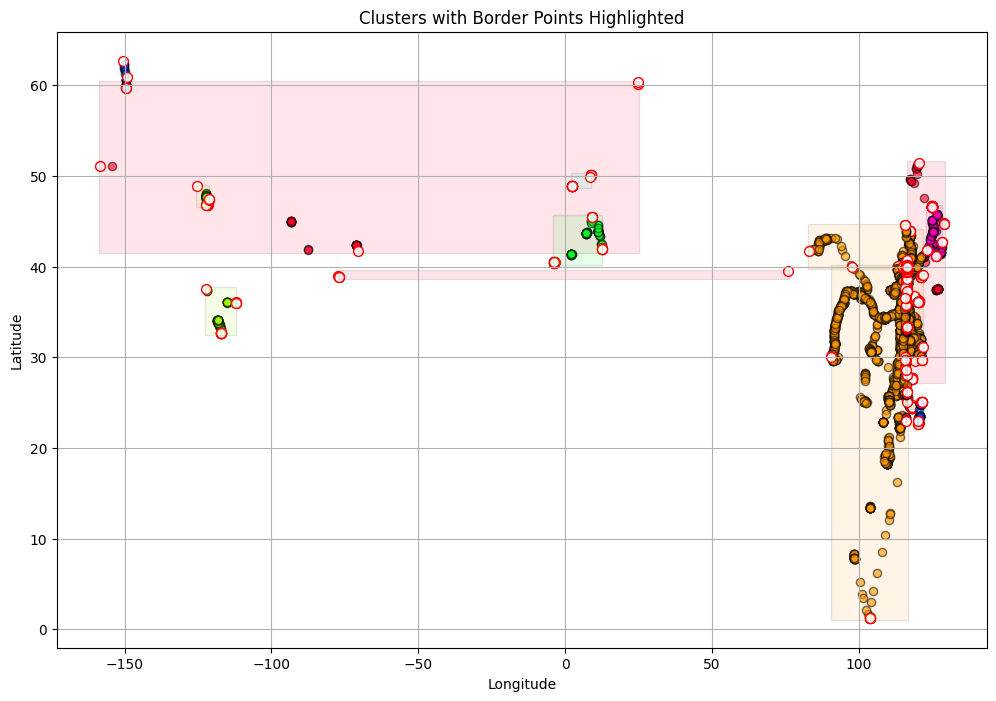

In [12]:


# Convert the DataFrame with border tags to Pandas for plotting
pandas_df_with_borders = df_with_borders.toPandas()

# Plotting the data
color_map = plt.cm.get_cmap('gist_rainbow')
colors = [color_map(each) for each in np.linspace(0, 1, len(np.unique(pandas_df_with_borders['Cluster'])))]

# Creating a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

# Group data by Partition_ID for plotting
partitions = pandas_df_with_borders['Partition_ID'].unique()

for partition_id in sorted(partitions):
    partition_data = pandas_df_with_borders[pandas_df_with_borders['Partition_ID'] == partition_id]
    clusters = partition_data['Cluster'].unique()

    for i, cluster in enumerate(sorted(clusters)):
        cluster_data = partition_data[partition_data['Cluster'] == cluster]
        color = colors[i % len(colors)]
        color_with_alpha = tuple(list(color[:3]) + [0.9])  # Reduce color brightness for visibility

        # Plotting all points in the cluster
        ax.scatter(cluster_data['Longitude'], cluster_data['Latitude'], color=color_with_alpha, edgecolor='black', s=35, alpha=0.6, label=f'Cluster {cluster}')
        
        # Highlight border points with a different shape or color
        border_data = cluster_data[cluster_data['IsBorder']]
        ax.scatter(border_data['Longitude'], border_data['Latitude'], s=50, color='white', edgecolor='red', linewidth=1, alpha=1, marker='o', label='Border Point' if i == 0 else "")

        # Optional: Draw a rectangle around cluster boundaries (adjust padding as needed)
        padding = 0.19
        min_long, max_long = cluster_data['Longitude'].min() - padding, cluster_data['Longitude'].max() + padding
        min_lat, max_lat = cluster_data['Latitude'].min() - padding, cluster_data['Latitude'].max() + padding
        rect = Rectangle((min_long, min_lat), max_long - min_long, max_lat - min_lat,
                         linewidth=1, edgecolor='black', facecolor=color_with_alpha, alpha=0.1)
        ax.add_patch(rect)

# Customizing the plot
ax.set_title('Clusters with Border Points Highlighted')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# # Move the legend outside of the plot on the right side
# ax.legend(title="Legend", loc='center left', bbox_to_anchor=(1, 0.5), shadow=True)

# # To prevent cutting off the legend, adjust the subplot parameters
# plt.subplots_adjust(right=0.75)

ax.grid(True)

# Display the plot
plt.show()


In [13]:
def calculate_local_eps(df):
    # Function to calculate a dynamic epsilon based on the nearest neighbor distance
    features = df[['Latitude', 'Longitude']].values
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(features)
    distances, indices = nbrs.kneighbors(features)
    # Use the mean distance to the second nearest neighbor as epsilon
    return np.mean(distances[:, 1]) * 0.5  # Scaling factor can be adjusted

def merge_clusters_optimized(df, dynamic_eps=True):
    print("Filtering border clusters...")
    border_clusters = df.filter(col('IsBorder')).select('Partition_ID', 'Cluster', 'Latitude', 'Longitude').distinct()
    
    # Convert Spark DataFrame to Pandas DataFrame
    pd_border_clusters = border_clusters.toPandas()

    # Optionally calculate a dynamic eps based on local density
    if dynamic_eps:
        eps = calculate_local_eps(pd_border_clusters)
    else:
        eps = 0.001  # default static eps value
    
    print(f"Using epsilon: {eps} for merging clusters")
    print(f"Number of border points for merging: {len(pd_border_clusters)}")

    # Build KDTree and query pairs
    print("Building KDTree...")
    tree = KDTree(pd_border_clusters[['Latitude', 'Longitude']])
    pairs = tree.query_pairs(r=eps)

    print("Building graph from pairs...")
    G = nx.Graph()
    for i, row in pd_border_clusters.iterrows():
        G.add_node((row['Partition_ID'], row['Cluster']), pos=(row['Latitude'], row['Longitude']))

    for i, j in pairs:
        G.add_edge((pd_border_clusters.iloc[i]['Partition_ID'], pd_border_clusters.iloc[i]['Cluster']),
                   (pd_border_clusters.iloc[j]['Partition_ID'], pd_border_clusters.iloc[j]['Cluster']))

    print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

    # Finding connected components for potential merged clusters
    merged_clusters = list(nx.connected_components(G))
    print(f"Number of merged clusters formed: {len(merged_clusters)}")

    return merged_clusters, pd_border_clusters, pairs

# Apply optimizations and check performance
merged_clusters, pd_border_clusters, pairs = merge_clusters_optimized(df_with_borders)


Filtering border clusters...


Using epsilon: 0.005274020062537043 for merging clusters
Number of border points for merging: 8652
Building KDTree...
Building graph from pairs...
Graph has 24 nodes and 38 edges
Number of merged clusters formed: 16


/tmp/ipykernel_4337/2822204550.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', total_new_clusters)  # Correctly define the number of clusters here


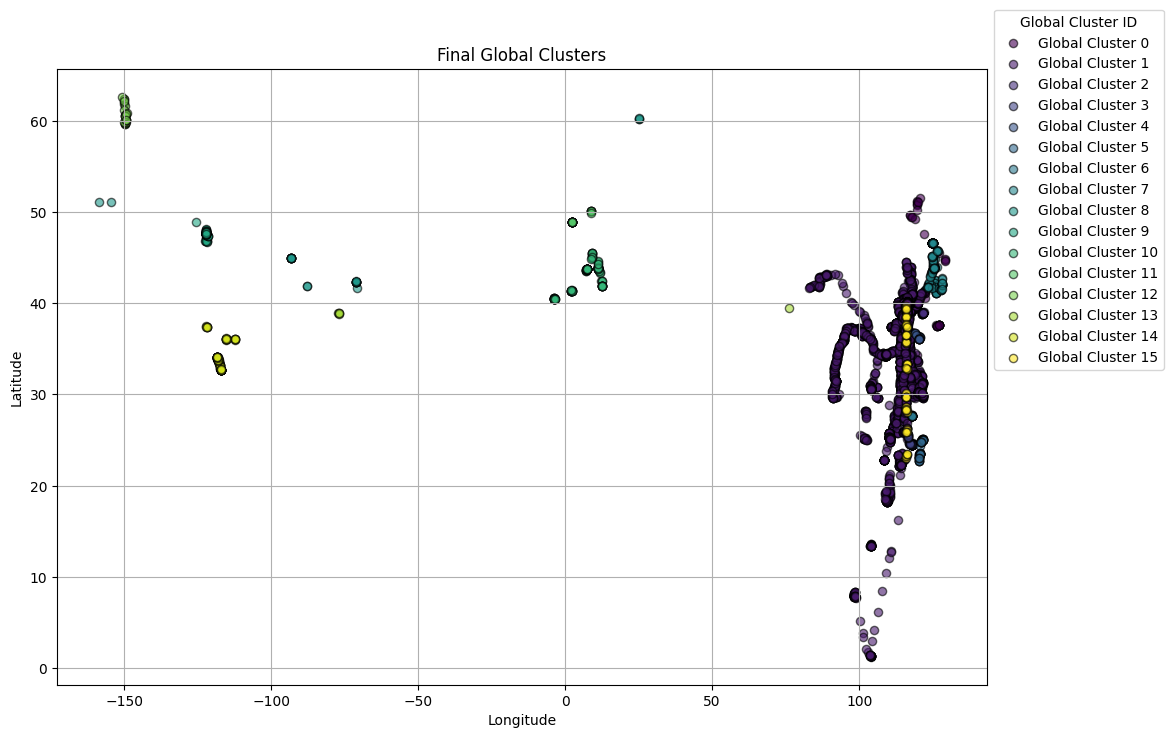

In [14]:


def update_cluster_labels(df, merged_clusters):
    # Create a dictionary to map old (Partition_ID, Cluster) to new Cluster IDs
    cluster_id_mapping = {}
    new_cluster_id = 0
    for cluster_group in merged_clusters:
        for part_cluster in cluster_group:
            cluster_id_mapping[part_cluster] = new_cluster_id
        new_cluster_id += 1

    # Function to map old cluster to new
    def map_clusters(partition_id, cluster_id):
        return cluster_id_mapping.get((partition_id, cluster_id), cluster_id)

    # Apply the mapping to the DataFrame
    udf_map_clusters = udf(map_clusters, IntegerType())
    df = df.withColumn('NewClusterID', udf_map_clusters('Partition_ID', 'Cluster'))
    
    return df, new_cluster_id  # Also return the number of new cluster IDs

# Update cluster labels in the DataFrame
df_with_new_clusters, total_new_clusters = update_cluster_labels(df_with_borders, merged_clusters)

# Convert to Pandas DataFrame for plotting
pandas_df_with_new_clusters = df_with_new_clusters.toPandas()

# Plotting the data
fig, ax = plt.subplots(figsize=(12, 8))
color_map = plt.cm.get_cmap('viridis', total_new_clusters)  # Correctly define the number of clusters here

# Group data by new cluster ID for plotting
for cluster_id, group in pandas_df_with_new_clusters.groupby('NewClusterID'):
    color = color_map(cluster_id)
    ax.scatter(group['Longitude'], group['Latitude'], color=color, label=f'Global Cluster {cluster_id}', s=35, alpha=0.6, edgecolor='black')

# Customizing the plot
ax.set_title('Final Global Clusters')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True)
ax.legend(title='Global Cluster ID', loc='lower left', bbox_to_anchor=(1, 0.5))

plt.show()

